# Skin Lesion Classification with a fully connected deep neural network

Most of the code in this notebook was taken from https://github.com/falloutdurham/beginners-pytorch-deep-learning/. Here, it was tweaked to solve the sking lesion classification problem 

Please refer to the following book for more details:
Programming PyTorch for Deep Learning by Ian Pointer - Released September 2019, Publisher(s): O'Reilly Media, Inc., ISBN: 9781492045342

### Imports

In [0]:
import pandas as pd
import os, os.path, shutil
import tqdm
import torch
from torch.optim import Optimizer 
import numpy as np
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

folder_path = "/content/drive/My Drive/Skin_Lesions"

## Dataset

The dataset used here is the training set avaiable at https://challenge.kitware.com/#challenge/560d7856cad3a57cfde481ba 

Parte 3: Lesion Classification.


### Split files

The code below can be used to creat an Image Folder of the aforementioned dataset in the following format:

**3 folders**: **train** (the trainning set), **val** (the validation set) and **test** (the test set)

Each folder contains **two subfolders**: **benign** (the benign skin lesion images) and **malignant** (the malignant skin lesion images)

In [0]:
# ##########
# # split_files.py
# ##########

# #Load ground truth file
# imagesDF = pd.read_csv("/content/drive/My Drive/GroundTruth.csv",names=['ID','class'])
# folder_path = "/content/drive/My Drive/Skin_Lesions"

# # Load images 
# images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# for row in imagesDF.itertuples():
#   fig_id = row[1]
#   fig_class = row[2]

#   cur_image = ''
#   for im in images:
#     im_name = im.split('.')[0]
#     if im_name == fig_id:
#       cur_image = im

#   r = np.random.rand()
#   if  r < 0.15:
#     set_type = 'val'
#   elif r > 0.15 and r <= 0.3:
#     set_type = 'test'
#   else:
#     set_type = 'train'

#   folder_name = set_type + '/' + fig_class

#   new_path = os.path.join(folder_path, folder_name)
#   if not os.path.exists(new_path):
#         os.makedirs(new_path)
  
#   old_image_path = os.path.join(folder_path, cur_image)
#   new_image_path = os.path.join(new_path, cur_image)
#   shutil.copy(old_image_path, new_image_path)

In [0]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

## Image resizing and normalization

In [0]:
im_size = 128

img_transforms = transforms.Compose([
    transforms.Resize((im_size,im_size)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

## Creating the DataLoaders

In [0]:
train_data_path = folder_path + "/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)

test_data_path = folder_path + "/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=img_transforms, is_valid_file=check_image)

val_data_path = folder_path + "/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)

In [0]:
batch_size = 64

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Visualize an image after transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


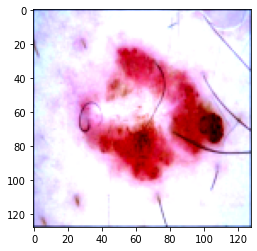

In [0]:
import matplotlib.pyplot as plt
img = val_data[4][0].permute(1, 2, 0).numpy()
plt.imshow(img)

## Creating a Deep fully connected neural network

In [0]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(im_size*im_size*3, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, im_size*im_size*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
simplenet = SimpleNet()

## Optimization settings

In [0]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print('Using GPU')
else:
    device = torch.device("cpu")
    print('Using CPU')

simplenet.to(device)

Using CPU


SimpleNet(
  (fc1): Linear(in_features=49152, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Trainning procedure

In [0]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

## Trainning

In [0]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=15, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 27.08, Validation Loss: 13.00, accuracy = 0.79
Epoch: 1, Training Loss: 1.08, Validation Loss: 5.60, accuracy = 0.19
Epoch: 2, Training Loss: 6.23, Validation Loss: 3.70, accuracy = 0.79
Epoch: 3, Training Loss: 0.48, Validation Loss: 4.86, accuracy = 0.24
Epoch: 4, Training Loss: 4.11, Validation Loss: 2.94, accuracy = 0.79
Epoch: 5, Training Loss: 0.39, Validation Loss: 3.19, accuracy = 0.28
Epoch: 6, Training Loss: 3.06, Validation Loss: 2.33, accuracy = 0.79
Epoch: 7, Training Loss: 0.38, Validation Loss: 2.48, accuracy = 0.32
Epoch: 8, Training Loss: 2.28, Validation Loss: 1.58, accuracy = 0.79
Epoch: 9, Training Loss: 0.37, Validation Loss: 1.43, accuracy = 0.42
Epoch: 10, Training Loss: 1.41, Validation Loss: 1.17, accuracy = 0.79
Epoch: 11, Training Loss: 0.32, Validation Loss: 1.12, accuracy = 0.55
Epoch: 12, Training Loss: 1.13, Validation Loss: 1.00, accuracy = 0.79
Epoch: 13, Training Loss: 0.40, Validation Loss: 0.90, accuracy = 0.69
Epoch: 14, Tra

## Test

In [0]:
import os, os.path

# path joining version for other paths
DIR = folder_path + '/train/malignant/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


DIR = folder_path + '/train/benign/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

116
498


In [0]:
labels = ['benign','maglinant']

folder_path = "/content/drive/My Drive/Skin_Lesions/test/malignant"

images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


In [0]:
for im in images:
  img = Image.open(folder_path + '/' + im) 
  img = img_transforms(img).to(device)

  prediction = F.softmax(simplenet(img))
  prediction = prediction.argmax()  
  print(labels[prediction] + '_' + str(prediction))


benign_tensor(0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
maglinant_tensor(1)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
maglinant_tensor(1)
benign_tensor(0)
maglinant_tensor(1)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
benign_tensor(0)
